# Анализ временнных рядов

**Препроцессинг и создание итогового датафрейма**

Данные формируются долго, поэтому я приложила итоговый датафрейм "data", который можно загрузить и работать с алгоритмом в разделе "Разработка модели"

In [1]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sea

Загружаем данные и дополнительную информацию

In [2]:
# load data

import json
import numpy as np

with open('time_series_train.json') as f:
    d = json.load(f)

values = []
times = []
for el in d:
    l1 = []
    l2 = []
    for val in el:
        l1.append(val[1])
        l2.append(val[0])
    values.append(l1)
    times.append(l2)

In [3]:
# load additional information

with open('additional_features.json') as f:
    info = json.load(f)

Посмотрим на несколько временных рядов

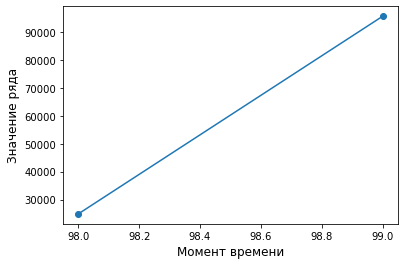

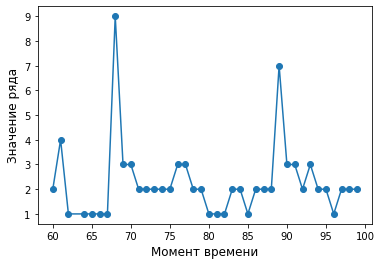

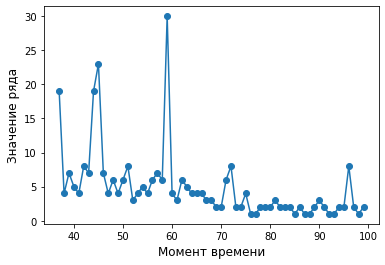

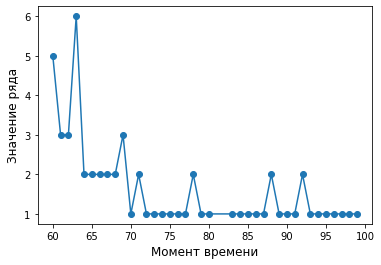

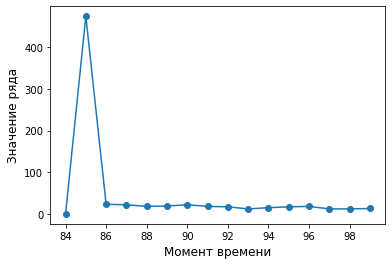

In [4]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.xlabel('Момент времени', fontsize=12)
    plt.ylabel('Значение ряда', fontsize=12)
    plt.plot(times[i], values[i], marker='o', linestyle = '-')
    plt.show()

Есть ряды с двумя точками, есть — с огромными выбросами

Посмотрим на длины рядов и построим гистограмму их распределения

In [5]:
lens = []
for el in values:
    lens.append(len(el))

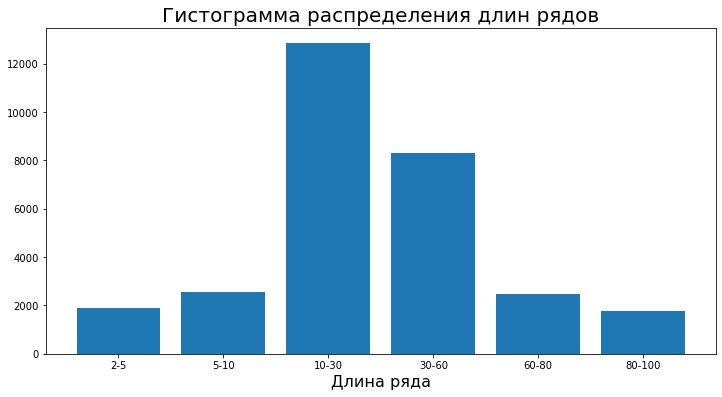

In [6]:
# histogram of lens 

heights, bins = np.histogram(lens, bins=[2, 5, 10, 30, 60, 80, 100])
bins = bins.round().astype(int)
bins_plot = ['{}-{}'.format(bins[i], bins[i + 1]) for i in range(len(bins) - 1)]

plt.figure(figsize=(12, 6))
plt.bar(bins_plot, heights)
plt.xlabel('Длина ряда', fontsize=16)
plt.title('Гистограмма распределения длин рядов', fontsize=20)
plt.show()

In [7]:
count = 0
for el in lens:
    if el < 10:
        count += 1
print('Число процентов рядов, длина которых меньше 10:', count / 29860 * 100, '%')

Число процентов рядов, длина которых меньше 10: 14.805760214333558 %


Гистограмма распределения говорит о том, что маленьких рядов довольно немного (рядов с длиной меньше 10 не более 15 %)

**Составление итогового датафрейма**

Функция для добавления лагов

In [8]:
def add_shift_cols(df_, shift_n=1):
    df = df_.copy()
    for i in range(shift_n):
        df[f'lag_{i+1}'] = df['y'].shift(i+1)
    return df

Совместим все ряды в единый датафрейм и будем обучать одну модель для всех рядов, что будет удобно и относителньо быстро.

Создание единого датафрейма из всех лагов всех рядов

In [9]:
def create_dataframe_lags(values, times, num_lags):
    list_series_big = []
    list_series_small = []

    df_ = pd.DataFrame({'time': [], 'num' : [], 'y' : []})
    df_list = []

    for i in tqdm(range(len(values))):
        df_temp = pd.DataFrame({'time' : times[i], 'num': np.repeat(i, len(times[i])), 'y' : values[i]})
        df_temp_shift = add_shift_cols(df_temp, num_lags)
        df_list.append(df_temp_shift)
        list_series_big.append(i)
        
    # make one dataframe
    df_ = pd.concat(df_list)
    df_.set_index(['num', 'time'], inplace=True)
    df_ = df_.loc[lambda x: x.lag_1.notna()]
    df_lags = df_.T.fillna(df_.iloc[:, 1:].median(axis=1)).T
    df_lags = df_lags.loc[slice(None, None), slice(70, None), :]
    return df_lags

Количество лагов я попыталась подобрать по валидации, здесь этот кусок кода не вставляю, но валидация дала num_lags = 10. Как я делала валидацию - ниже.

In [10]:
num_lags = 10
df = create_dataframe_lags(values, times, num_lags)

100%|██████████| 29860/29860 [04:09<00:00, 119.75it/s]


In [11]:
df

y    lag_1    lag_2    lag_3    lag_4    lag_5    lag_6  \
num   time                                                                  
0     99    95644.0  24850.0  24850.0  24850.0  24850.0  24850.0  24850.0   
1     70        3.0      3.0      9.0      1.0      1.0      1.0      1.0   
      71        2.0      3.0      3.0      9.0      1.0      1.0      1.0   
      72        2.0      2.0      3.0      3.0      9.0      1.0      1.0   
      73        2.0      2.0      2.0      3.0      3.0      9.0      1.0   
...             ...      ...      ...      ...      ...      ...      ...   
29859 95        1.0      0.0      1.0      1.0      0.0      1.0      1.0   
      96        0.0      1.0      0.0      1.0      1.0      0.0      1.0   
      97        1.0      0.0      1.0      0.0      1.0      1.0      0.0   
      98        1.0      1.0      0.0      1.0      0.0      1.0      1.0   
      99        1.0      1.0      1.0      0.0      1.0      0.0      1.0   

              lag_7    lag_8    lag_9   lag_10  
num   time                                      
0     99    24850.0  24850.0  24850.0  24850.0  
1     70        1.0      4.0      2.0      1.0  
      71        1.0      1.0      4.0      2.0  
      72        1.0      1.0      1.0      4.0  
      73        1.0      1.0      1.0      1.0  
...             ...      ...      ...      ...  
29859 95        1.0      1.0      1.0      1.0  
      96        1.0      1.0      1.0      1.0  
      97        1.0      1.0      1.0      1.0  
      98        0.0      1.0      1.0      1.0  
      99        1.0      0.0      1.0      1.0  

[615864 rows x 11 columns]

Добавляем в датафрейм категориальные столбцы

In [12]:
df['categories'] = np.nan
df['classes'] = np.nan
df['characteristics'] = np.nan

In [18]:
for el in tqdm(info):
    df.loc[(el['index'], slice(None, None)), 'categories'] = df.loc[(el['index'], slice(None, None)), 'categories'].apply(lambda x: el['categories'])
    df.loc[(el['index'], slice(None, None)), 'classes'] = df.loc[(el['index'], slice(None, None)), 'classes'].apply(lambda x: el['classes'])
    df.loc[(el['index'], slice(None, None)), 'characteristics'] = df.loc[(el['index'], slice(None, None)), 'characteristics'].apply(lambda x: el['characteristics'])

100%|██████████| 28022/28022 [1:09:52<00:00,  6.68it/s]


В категориальных столбцах элементами являются списки, так что будем использовать для кодирования MultiLabelBinarizer, предварительно сделав из списка строку.

In [63]:
df_['categories'] = str(df_['categories'].tolist()).replace("[","")
df_['categories'] = str(df_['categories'].tolist()).replace("]","")
df_['categories'] = str(df_['categories'].tolist()).str.replace("'","")

df_['classes'] = df_['classes'].tolist().str.replace("[","")
df_['classes'] = df_['classes'].tolist().str.replace("]","")
df_['classes'] = df_['classes'].tolist().str.replace("'","")

df_['characteristics'] = df_['characteristics'].tolist().str.replace("[","")
df_['characteristics'] = df_['characteristics'].tolist().str.replace("]","")
df_['characteristics'] = df_['characteristics'].tolist().str.replace("'","")

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

encoded = pd.DataFrame(mlb.fit_transform(df['categories'].fillna('missing').str.split(', ')), columns=mlb.classes_, index=df.iloc[:, :-3].index)
df_ready = pd.concat([df.iloc[:, :-3], encoded], axis=1)

encoded = pd.DataFrame(mlb.fit_transform(df['classes'].fillna('missing').str.split(', ')), columns=mlb.classes_, index=df_ready.index)
df_ready = pd.concat([df_ready, encoded], axis=1)

encoded = pd.DataFrame(mlb.fit_transform(df['characteristics'].fillna('missing').str.split(', ')), columns=mlb.classes_, index=df_ready.index)
df_ready = pd.concat([df_ready, encoded], axis=1)

Посмотрим на получившиеся столбцы

In [ ]:
list(df_ready.columns)

In [ ]:
df_val_ready_append.drop(['', 'missing'], axis=1, inplace=True)

In [ ]:
df_val_ready_append = df_val_ready_append.loc[:, ~df_val_ready_append.columns.duplicated()]

Добавим столбец cost

In [ ]:
list_dict = dict()

for el in info:
    di = dict()
    for e in el['price_changes']:
        di[e['time']] = e['cost']
    list_dict[el['index']] = di

In [ ]:
df = pd.DataFrame({'time': [], 'num' : [], 'cost' : []})
df_list = []
for key in list_dict:
    df_temp = pd.DataFrame({'time': list_dict[key].keys(), 'num' : np.repeat(key, len(list_dict[key])), 'cost' : list_dict[key].values()})
    df_temp['num'] = key
    df_list.append(df_temp)
df = pd.concat(df_list)

In [ ]:
df = df.merge(df, on=['num', 'time'], how='left')

In [ ]:
df_val_["cost"] = df_val_["cost"].fillna(method='ffill')
df_val_["cost"] = df_val_["cost"].fillna(method='bfill')

Для маленьких рядов сделаем копию, чтобы было удобно валидироваться и увеличить информацию о численных рядах для обучения. С количеством сэмплов, конечно, надо бы поработать.

In [ ]:
small_blocks = []
ind_small_blocks = []
for num in df_ready_.index.get_level_values('num').unique():
    if df_ready_.loc[num].shape[0] < 5:
        small_blocks.append(df_ready_.loc[num].shape[0])
        ind_small_blocks.append(num)

In [ ]:
last_vals = df_lags.loc[ind_small_blocks, slice(None, None), :].groupby(level=0).last()
last_vals

In [ ]:
last_vals['time'] = 87
last_vals['num'] = last_vals.index
last_vals = last_vals.set_index(['num', 'time'])

In [ ]:
df_val_ready_append = pd.concat([df_val_ready_.reset_index(), last_vals.reset_index()]).sort_values(['num', 'time']).set_index(['num', 'time'])

Загружаем итовый датасет

In [ ]:
df_val_ready_append.to_csv('data', index=True)

# Разработка модели # 

In [70]:
# load data
import pandas as pd

df = pd.read_csv('data')
df.set_index(['num', 'time'], inplace=True)

In [71]:
df

y    lag_1    lag_2    lag_3    lag_4    lag_5    lag_6  \
num   time                                                                  
0     87    95644.0  24850.0  24850.0  24850.0  24850.0  24850.0  24850.0   
      99    95644.0  24850.0  24850.0  24850.0  24850.0  24850.0  24850.0   
1     70        3.0      3.0      9.0      1.0      1.0      1.0      1.0   
      71        2.0      3.0      3.0      9.0      1.0      1.0      1.0   
      72        2.0      2.0      3.0      3.0      9.0      1.0      1.0   
...             ...      ...      ...      ...      ...      ...      ...   
29859 95        1.0      0.0      1.0      1.0      0.0      1.0      1.0   
      96        0.0      1.0      0.0      1.0      1.0      0.0      1.0   
      97        1.0      0.0      1.0      0.0      1.0      1.0      0.0   
      98        1.0      1.0      0.0      1.0      0.0      1.0      1.0   
      99        1.0      1.0      1.0      0.0      1.0      0.0      1.0   

              lag_7    lag_8    lag_9  ...  remote play on tablet  \
num   time                             ...                          
0     87    24850.0  24850.0  24850.0  ...                    1.0   
      99    24850.0  24850.0  24850.0  ...                    1.0   
1     70        1.0      4.0      2.0  ...                    2.0   
      71        1.0      1.0      4.0  ...                    2.0   
      72        1.0      1.0      1.0  ...                    4.0   
...             ...      ...      ...  ...                    ...   
29859 95        1.0      1.0      1.0  ...                    0.0   
      96        1.0      1.0      1.0  ...                    0.0   
      97        1.0      1.0      1.0  ...                    0.0   
      98        0.0      1.0      1.0  ...                    0.0   
      99        1.0      0.0      1.0  ...                    0.0   

            remote play on tv  remote play together  shared/split screen  \
num   time                                                                 
0     87                  0.0                   0.0                  0.0   
      99                  0.0                   0.0                  0.0   
1     70                  2.0                   2.0                  2.0   
      71                  2.0                   2.0                  2.0   
      72                  4.0                   4.0                  4.0   
...                       ...                   ...                  ...   
29859 95                  0.0                   0.0                  0.0   
      96                  0.0                   0.0                  0.0   
      97                  0.0                   0.0                  0.0   
      98                  0.0                   0.0                  0.0   
      99                  0.0                   0.0                  0.0   

            shared/split screen co-op  shared/split screen pvp  single-player  \
num   time                                                                      
0     87                          0.0                      0.0            1.0   
      99                          0.0                      0.0            1.0   
1     70                          2.0                      2.0            2.0   
      71                          2.0                      2.0            2.0   
      72                          4.0                      4.0            4.0   
...                               ...                      ...            ...   
29859 95                          0.0                      0.0            0.0   
      96                          0.0                      0.0            0.0   
      97                          0.0                      0.0            0.0   
      98                          0.0                      0.0            0.0   
      99                          0.0                      0.0            0.0   

            stats  vr support   cost  
num   time                          

In [66]:
# ignore warnings

import warnings
warnings.filterwarnings("ignore")

В последствии будем обучаться на вновь добавленных значениях, так что сохраним информацию о дополнительных фичах в отдельную таблицу

In [72]:
df_append_features = df.iloc[:, 11:]

Добавим статистические характеристики рядов

In [21]:
# append statistical info

def append_statistical_info(df_, win_size):
    df = df_.copy()
    df[f'mean_{win_size}'] = df.iloc[:, 1:win_size+1].mean(axis=1)
    df[f'median_{win_size}'] = df.iloc[:, 1:win_size+1].median(axis=1)
    df[f'std_{win_size}'] = df.iloc[:, 1:win_size+1].std(axis=1)
    df[f'q_25_{win_size}'] = df.iloc[:, 1:win_size+1].quantile(q=0.25, axis=1)
    df[f'q_75_{win_size}'] = df.iloc[:, 1:win_size+1].quantile(q=0.75, axis=1)
    df[f'max_{win_size}'] = df.iloc[:, 1:win_size+1].max(axis=1)
    df[f'min_{win_size}'] = df.iloc[:, 1:win_size+1].min(axis=1)
    return df

df = append_statistical_info(df, 2)
df = append_statistical_info(df, 3)
df = append_statistical_info(df, 4)


# len of series
time_len = []
i = 0
for num, new_df in df.groupby(level=0):
    time_len.append([len(times[i])]*new_df.shape[0])
    i += 1
time_len = [item for sublist in time_len for item in sublist]

df["len"] = time_len

# разница между последним и предпоследним значением 

df["dif1"] = df.iloc[:, 1] - df.iloc[:, 2]
df["dif2"] = df.iloc[:, 2] - df.iloc[:, 3]

In [22]:
df

y    lag_1    lag_2    lag_3    lag_4    lag_5    lag_6  \
num   time                                                                  
0     87    95644.0  24850.0  24850.0  24850.0  24850.0  24850.0  24850.0   
      99    95644.0  24850.0  24850.0  24850.0  24850.0  24850.0  24850.0   
1     70        3.0      3.0      9.0      1.0      1.0      1.0      1.0   
      71        2.0      3.0      3.0      9.0      1.0      1.0      1.0   
      72        2.0      2.0      3.0      3.0      9.0      1.0      1.0   
...             ...      ...      ...      ...      ...      ...      ...   
29859 95        1.0      0.0      1.0      1.0      0.0      1.0      1.0   
      96        0.0      1.0      0.0      1.0      1.0      0.0      1.0   
      97        1.0      0.0      1.0      0.0      1.0      1.0      0.0   
      98        1.0      1.0      0.0      1.0      0.0      1.0      1.0   
      99        1.0      1.0      1.0      0.0      1.0      0.0      1.0   

              lag_7    lag_8    lag_9  ...    mean_4  median_4     std_4  \
num   time                             ...                                 
0     87    24850.0  24850.0  24850.0  ...  24850.00   24850.0  0.000000   
      99    24850.0  24850.0  24850.0  ...  24850.00   24850.0  0.000000   
1     70        1.0      4.0      2.0  ...      3.50       2.0  3.785939   
      71        1.0      1.0      4.0  ...      4.00       3.0  3.464102   
      72        1.0      1.0      1.0  ...      4.25       3.0  3.201562   
...             ...      ...      ...  ...       ...       ...       ...   
29859 95        1.0      1.0      1.0  ...      0.50       0.5  0.577350   
      96        1.0      1.0      1.0  ...      0.75       1.0  0.500000   
      97        1.0      1.0      1.0  ...      0.50       0.5  0.577350   
      98        0.0      1.0      1.0  ...      0.50       0.5  0.577350   
      99        1.0      0.0      1.0  ...      0.75       1.0  0.500000   

              q_25_4   q_75_4    max_4    min_4  len  dif1  dif2  
num   time                                                        
0     87    24850.00  24850.0  24850.0  24850.0    2   0.0   0.0  
      99    24850.00  24850.0  24850.0  24850.0    2   0.0   0.0  
1     70        1.00      4.5      9.0      1.0   39  -6.0   8.0  
      71        2.50      4.5      9.0      1.0   39   0.0  -6.0  
      72        2.75      4.5      9.0      2.0   39  -1.0   0.0  
...              ...      ...      ...      ...  ...   ...   ...  
29859 95        0.00      1.0      1.0      0.0   22  -1.0   0.0  
      96        0.75      1.0      1.0      0.0   22   1.0  -1.0  
      97        0.00      1.0      1.0      0.0   22  -1.0   1.0  
      98        0.00      1.0      1.0      0.0   22   1.0  -1.0  
      99        0.75      1.0      1.0      0.0   22   0.0   1.0  

[618271 rows x 515 columns]

Функция для добавления лагов

In [23]:
# add shift

def add_shift_cols(df_, shift_n=1):
    df = df_.copy()
    for i in range(shift_n):
        df[f'lag_{i+1}'] = df['y'].shift(i+1)
    return df

In [24]:
# weights for calcutation of errors

weights = []
for one_sequence in d:
    w = float(np.mean(np.abs((np.diff([x[1] for x in one_sequence])))))
    weights.append(w)

weights = [
    1 / (1 + weight)
    for weight in weights
]

**Обучение и предсказания**

Будем настраивать градиентный бустинг, причем сразу на ошибку mase засчет весов, приготовленных заранее.

LGBMRegressor работает быстро, что крайне удобно, в отличие от xgboost.

На валидации обучаемся на всех значениях вплоть до 97 и делаем предсказание на 98 на один шаг вперед.

In [25]:
# train and test dataframes

# delete unpropriate symbols in columns' names
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df = df.loc[:,~df.columns.duplicated()]

df_val_train = df.loc[slice(None, None), slice(None, 97), :]

df_val_test = df.groupby(level=0).tail(2)
df_val_test = df_val_test.groupby(level=0).first(1)

X_train = df_val_train.iloc[:, 1:]
y_train = df_val_train.iloc[:, 0]

X_test = df_val_test.iloc[:, 1:]

# true values for validation

df_val_true = df.loc[slice(None, None), slice(99, 99), :]
y_true = df_val_true.iloc[:, 0].to_numpy()

Веса для всех рядов

In [26]:
weights_all = []
i = 0
for num, new_df in y_train.groupby(level=0):
    weights_all.append([weights[i]]*new_df.shape[0])
    i += 1
weights_all = [item for sublist in weights_all for item in sublist]

Валидация модели и подбор гиперпараметров

In [28]:
# validation

from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor


parameters = {'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
              'n_estimators': [300, 500, 800, 1000, 1500, 2000], 
              'max_depth' : [5, 7, 9, 11, 13], 
              'metric' : ["mae"],
              'reg_lambda' : [0, 0.5, 1, 1.5, 2]
             }

# model = GridSearchCV(LGBMRegressor(silent=False), param_grid=parameters,
#                    cv=4, n_jobs=-1, verbose=3, scoring='neg_mean_absolute_error')

model = LGBMRegressor(silent=False, learning_rate=0.05, n_estimators=1000, max_depth=11, reg_lambda=1, metric="mae")
    
model.fit(X_train, y_train, sample_weight = weights_all)
y_pred = model.predict(X_test)

y_pred_ = [int(round(el)) for el in y_pred]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 4.912096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 129895
[LightGBM] [Info] Number of data points in the train set: 559159, number of used features: 510
[LightGBM] [Info] Start training from score 3.095601


In [29]:
# calculate error on validation
from sklearn.metrics import mean_absolute_error
print('Ошибка на валидации:', mean_absolute_error(y_true, y_pred_, weights))

Ошибка на валидации: 0.836308697843626


На лидерборде ошибка была значительно меньше (примерно 0.54). Над валидацией надо было бы еще поработать. Видимо, все-таки надо было валидироваться на трех предсказаниях.

Отбираем значимые фичи

In [30]:
ind_imp = []
for i in range(len(model.feature_importances_)):
    if model.feature_importances_[i] != 0:
        ind_imp.append(i+1)
        
df = df.iloc[:, ind_imp]

In [31]:
print('Количество значимых фичей:', len(ind_imp))

Количество значимых фичей: 171


Посмотрим на то, какие фичи оказались значимыми.

In [37]:
list(df.columns)

['lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'lag_8',
 'lag_9',
 'lag_10',
 'EA',
 'FTP',
 'actions',
 'adventures',
 'casual',
 'indiegame',
 'racingsimulator',
 'rpg',
 'simulation',
 'sport',
 'strategies',
 'tagBeatemup',
 'theme_1990S',
 '25d',
 '2d',
 'action',
 'addictive',
 'adventure',
 'anime',
 'arcade',
 'board__game',
 'building',
 'casual1',
 'choices__matter',
 'city__builder',
 'classic',
 'coop',
 'colony__sim',
 'colorful',
 'competitive',
 'crafting',
 'cute',
 'dark',
 'destruction',
 'difficult',
 'dystopian__',
 'exploration',
 'fantasy',
 'fighting',
 'firstperson',
 'flight',
 'football',
 'fps',
 'free__to__play',
 'funny',
 'gambling',
 'game_Atmospheric',
 'game_Economy',
 'game_FemaleProtagonist',
 'game_Horror',
 'game_PsychologicalHorror',
 'game_Retro',
 'god__game',
 'gore',
 'historical',
 'indie',
 'jrpg',
 'local__multiplayer',
 'magic',
 'management',
 'massively__multiplayer',
 'mature',
 'missing1',
 'multiplayer1',
 'myst

Все лаги, статистические характеристики оказались значимыми, также некоторые категории, то есть, дополнительная информация также дает прирост полезной информации.

Делаем предсказание для точки 100 с лучшими подобранными параметрами

In [38]:
def make_prediction(df, model, weights, num):
    
    df_val_train = df.loc[slice(None, None), slice(None, num-2), :]
    df_val_test = df.loc[slice(None, None), slice(num-1, num-1), :]

    X_train = df_val_train.iloc[:, 1:]
    y_train = df_val_train.iloc[:, 0]

    X_test = df_val_test.iloc[:, 1:]

    weights_all = []
    i = 0
    for num, new_df in y_train.groupby(level=0):
        weights_all.append([weights[i]]*new_df.shape[0])
        i += 1
    
    weights_all = [item for sublist in weights_all for item in sublist]

    model.fit(X_train, y_train, sample_weight = weights_all)
    y_pred_1 = model.predict(X_test)

    y_pred_1 = [int(round(el)) for el in y_pred_1]
    
    return y_pred_1

In [39]:
# make first prediction (100)
y_pred_1 = make_prediction(df, model, weights, 100)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.125417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43195
[LightGBM] [Info] Number of data points in the train set: 588411, number of used features: 170
[LightGBM] [Info] Start training from score 3.169771


Добавляем предсказанное значение и вновь создаем датасет с ним уже

In [40]:
# append prediction
j = 0
for i in range(29860):
    values[i].append(y_pred_1[j])
    j+=1
    times[i].append(100)

In [41]:
from tqdm import tqdm

df = create_dataframe_lags(values, times, num_lags)

100%|██████████| 29860/29860 [03:40<00:00, 135.71it/s]


In [42]:
df

y    lag_1    lag_2    lag_3    lag_4    lag_5    lag_6  \
num   time                                                                  
0     99    95644.0  24850.0  24850.0  24850.0  24850.0  24850.0  24850.0   
      100   24039.0  95644.0  24850.0  60247.0  60247.0  60247.0  60247.0   
1     70        3.0      3.0      9.0      1.0      1.0      1.0      1.0   
      71        2.0      3.0      3.0      9.0      1.0      1.0      1.0   
      72        2.0      2.0      3.0      3.0      9.0      1.0      1.0   
...             ...      ...      ...      ...      ...      ...      ...   
29859 96        0.0      1.0      0.0      1.0      1.0      0.0      1.0   
      97        1.0      0.0      1.0      0.0      1.0      1.0      0.0   
      98        1.0      1.0      0.0      1.0      0.0      1.0      1.0   
      99        1.0      1.0      1.0      0.0      1.0      0.0      1.0   
      100       1.0      1.0      1.0      1.0      0.0      1.0      0.0   

              lag_7    lag_8    lag_9   lag_10  
num   time                                      
0     99    24850.0  24850.0  24850.0  24850.0  
      100   60247.0  60247.0  60247.0  60247.0  
1     70        1.0      4.0      2.0      1.0  
      71        1.0      1.0      4.0      2.0  
      72        1.0      1.0      1.0      4.0  
...             ...      ...      ...      ...  
29859 96        1.0      1.0      1.0      1.0  
      97        1.0      1.0      1.0      1.0  
      98        0.0      1.0      1.0      1.0  
      99        1.0      0.0      1.0      1.0  
      100       1.0      1.0      0.0      1.0  

[645724 rows x 11 columns]

In [43]:
def append_add_info(df, df_append_features, num):
    last_vals = df_append_features.groupby(level=0).last()
    last_vals['time'] = num
    last_vals['num'] = last_vals.index
    last_vals = last_vals.set_index(['num', 'time'])
    
    df_append_features = pd.concat([df_append_features.reset_index(), last_vals.reset_index()])\
    .sort_values(['num', 'time'])\
    .set_index(['num', 'time'])
    
    df = pd.concat([df, df_append_features], axis=1)
    df = df.fillna(method='bfill')
    
    return df

In [44]:
df = append_add_info(df, df_append_features, 100)

Добавляем статистические признаки

In [45]:
df = append_statistical_info(df, 2)
df = append_statistical_info(df, 3)
df = append_statistical_info(df, 4)


# len of series
time_len = []
i = 0
for num, new_df in df.groupby(level=0):
    time_len.append([len(times[i])]*new_df.shape[0])
    i += 1
time_len = [item for sublist in time_len for item in sublist]

df["len"] = time_len

# разница между последним и предпоследним значением 

df["dif1"] = df.iloc[:, 1] - df.iloc[:, 2]
df["dif2"] = df.iloc[:, 2] - df.iloc[:, 3]

Делаем предсказание для точки 101

In [46]:
df.sort_index(inplace=True)
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df = df.loc[:,~df.columns.duplicated()]

In [47]:
y_pred_2 = make_prediction(df, model, weights, 101)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 5.165609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 129895
[LightGBM] [Info] Number of data points in the train set: 618271, number of used features: 510
[LightGBM] [Info] Start training from score 3.005146


Добавляем предсказанное значение и вновь создаем датасет с ним уже

In [48]:
# append prediction
j = 0
for i in range(29860):
    values[i].append(y_pred_2[j])
    j+=1
    times[i].append(101)

In [49]:
df = create_dataframe_lags(values, times, num_lags)

100%|██████████| 29860/29860 [03:49<00:00, 130.17it/s]


In [50]:
df = append_add_info(df, df_append_features, 101)

In [51]:
df = append_statistical_info(df, 2)
df = append_statistical_info(df, 3)
df = append_statistical_info(df, 4)


# len of series
time_len = []
i = 0
for num, new_df in df.groupby(level=0):
    time_len.append([len(times[i])]*new_df.shape[0])
    i += 1
time_len = [item for sublist in time_len for item in sublist]

df["len"] = time_len

# разница между последним и предпоследним значением 

df["dif1"] = df.iloc[:, 1] - df.iloc[:, 2]
df["dif2"] = df.iloc[:, 2] - df.iloc[:, 3]

Делаем предсказание для точки 102

In [52]:
df.sort_index(inplace=True)
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df = df.loc[:,~df.columns.duplicated()]

In [53]:
y_pred_3 = make_prediction(df, model, weights, 102)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 6.791681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 129895
[LightGBM] [Info] Number of data points in the train set: 648131, number of used features: 510
[LightGBM] [Info] Start training from score 2.965278


Собираем все предсказания вместе 

In [54]:
for i in range(len(y_pred_1)):
    if y_pred_1[i] < 0:
        y_pred_1[i] = 0
        
for i in range(len(y_pred_2)):
    if y_pred_2[i] < 0:
        y_pred_2[i] = 0
        
for i in range(len(y_pred_3)):
    if y_pred_3[i] < 0:
        y_pred_3[i] = 0

In [55]:
res = []
for i in range(29860):
    res.append([int(round(y_pred_1[i])), int(round(y_pred_2[i])), int(round(y_pred_3[i]))])
    
result = []
for i in range(29860):
    result.append(res[i])

Отрисуем несколько рядов с предсказаниями

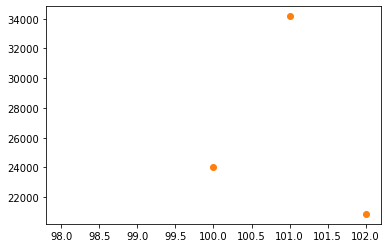

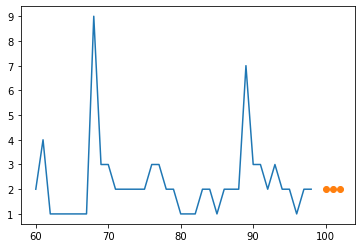

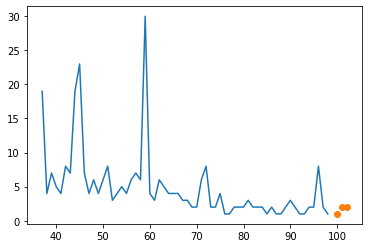

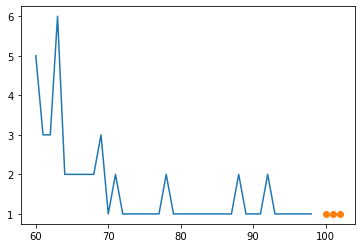

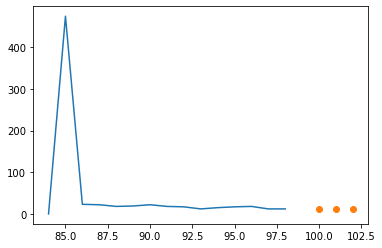

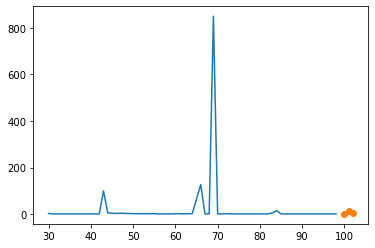

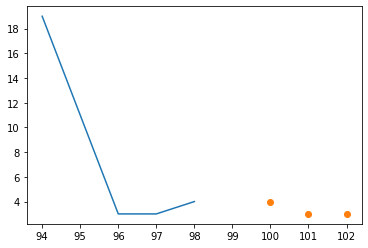

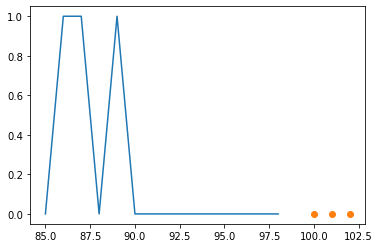

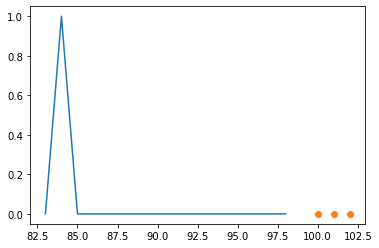

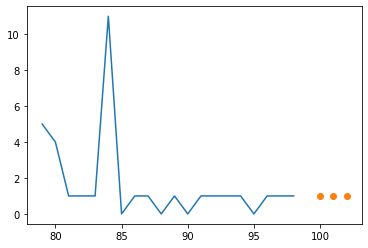

In [56]:
import matplotlib.pyplot as plt

for i in range(10):
    plt.plot(times[i][:-3], values[i][:-3])
    plt.plot(range(100, 103), result[i], 'o')
    plt.show()

Создаем итоговый датафрейм с предсказаниями

In [57]:
# dataframe of results

import pandas as pd
col1 = []
col2 = []

k = 0
for el in result:
    for i in range(3):
        col1.append(str(k) + '_' + str(i))
        col2.append(el[i])
    k += 1
    
list_res = []
list_res.append(col1)
list_res.append(col2)
df = pd.DataFrame(list_res)
df = df.transpose()
df.columns = ['Id', 'Predicted']

df.to_csv('time_series_pred', index=False)

Данное решение дало неплохой скор, однако его можно улучшить генерацией признаков, сэмплированием рядов, лучшей настройкой гиперпараметов, однако времени уже не хватило:(
Еше бы побольше ресурсов, можно было бы сделать побольше матрицу, и это тоже, скорее всего, бы поспособствовало улучшению скора.